# <center> International Energy Statistics Analysis
### <center> Adam Brenner

#### Dataset:
The dataset for this final project was originally published by the United Nations Statistics Division on the UNData site. However, I collected the dataset from Kaggle here, https://www.kaggle.com/unitednations/international-energy-statistics. With the human population reaching 7.8 billion in March of 2020, energy technologies will continue to be a major topic into the future. The data was collected using the UNSD Annual Questionnaire on Energy Statistics and is part of the UNSD data collection program. "It covers statistics such as production, transformation and use of energy products in physical and energy units. The Questionnaire is the primary source of information for the UNSD Energy Statistics Database and contributes to the Energy Statistics Yearbook, the Energy Balances, the Electricity Profiles and the Energy Statistics Pocketbook publications" (1). The dataset is explained in more detail below.

#### Research Question:
What countries are producing and using more outdated energy technologies?  

What countries are producing and using newer energy technologies?

In [1]:
%config Completer.use_jedi = False

In [2]:
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

In [3]:
energy = pd.read_csv('./all_energy_statistics.csv', parse_dates = True)
energy.head()

,country_or_area,commodity_transaction,year,unit,quantity,quantity_footnotes,category
0,Austria,Additives and Oxygenates - Exports,1996,"Metric tons, thousand",5.0,NaN,additives_and_oxygenates
1,Austria,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",17.0,NaN,additives_and_oxygenates
2,Belgium,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
3,Belgium,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",0.0,NaN,additives_and_oxygenates
4,Belgium,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",35.0,NaN,additives_and_oxygenates


In [4]:
energy.shape

(1189482, 7)

In [5]:
# for c in energy.columns:
#     print(c, energy[c].unique(), '\n')

### <center> Data Cleaning

Describe doesn't give us much information as we are not interested in the mean and such of the entire dataset but instead of different countries or areas as well as different energy sources.

In [6]:
energy.describe()

,year,quantity,quantity_footnotes
count,1.189482e+06,1.189482e+06,163946.0
mean,2.002852e+03,1.842648e+05,1.0
std,7.167345e+00,1.585663e+07,0.0
min,1.990000e+03,-8.643480e+05,1.0
25%,1.997000e+03,1.400000e+01,1.0
50%,2.003000e+03,1.890000e+02,1.0
75%,2.009000e+03,2.265000e+03,1.0
max,2.014000e+03,6.680329e+09,1.0


In [7]:
energy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1189482 entries, 0 to 1189481
Data columns (total 7 columns):
country_or_area          1189482 non-null object
commodity_transaction    1189482 non-null object
year                     1189482 non-null int64
unit                     1189482 non-null object
quantity                 1189482 non-null float64
quantity_footnotes       163946 non-null float64
category                 1189482 non-null object
dtypes: float64(2), int64(1), object(4)
memory usage: 63.5+ MB


Looking at the info for the dataset it seems that 'quantity_footnotes' is missing a lot of entries. So how should we handle them?

In [8]:
energy['quantity_footnotes'].unique()

array([nan,  1.])

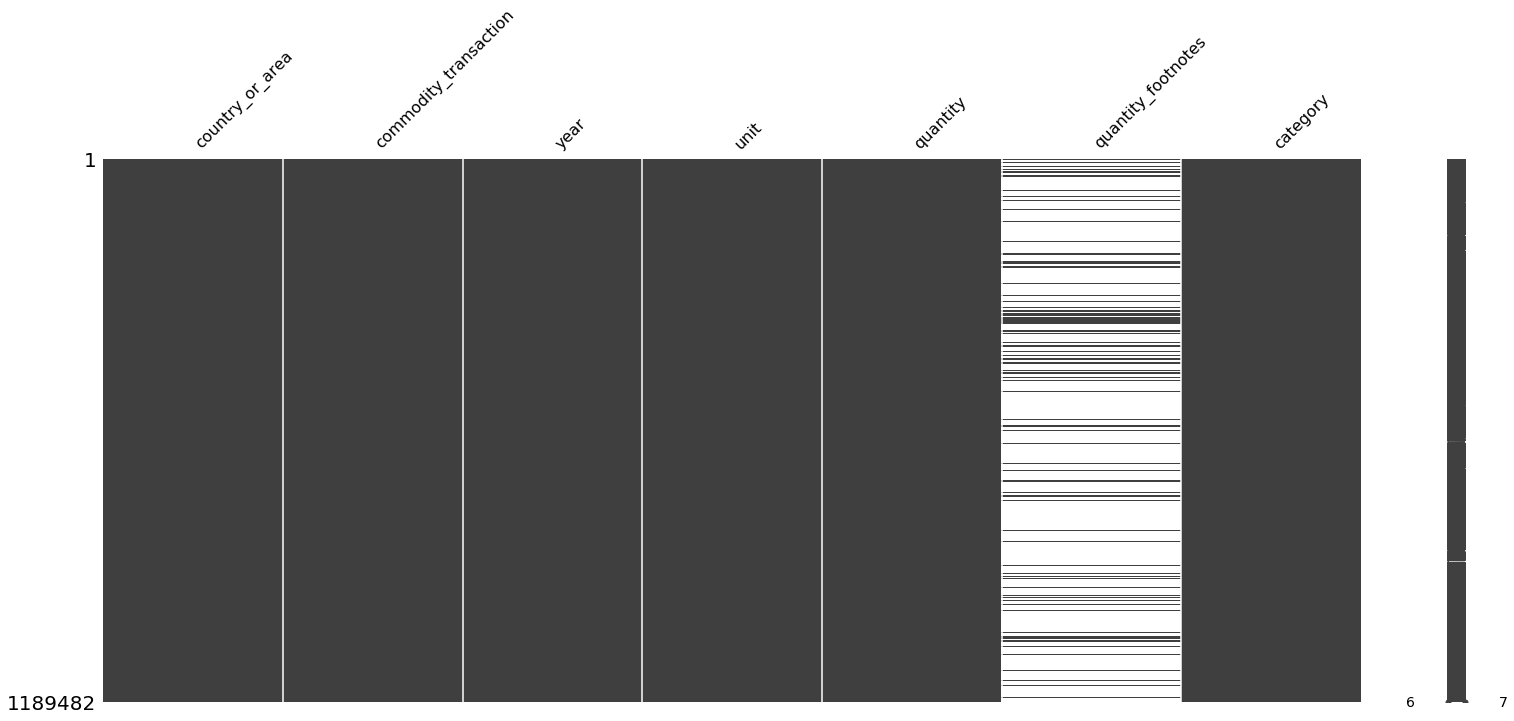

In [9]:
# Checking missing values graphically
msno.matrix(energy)
plt.show()

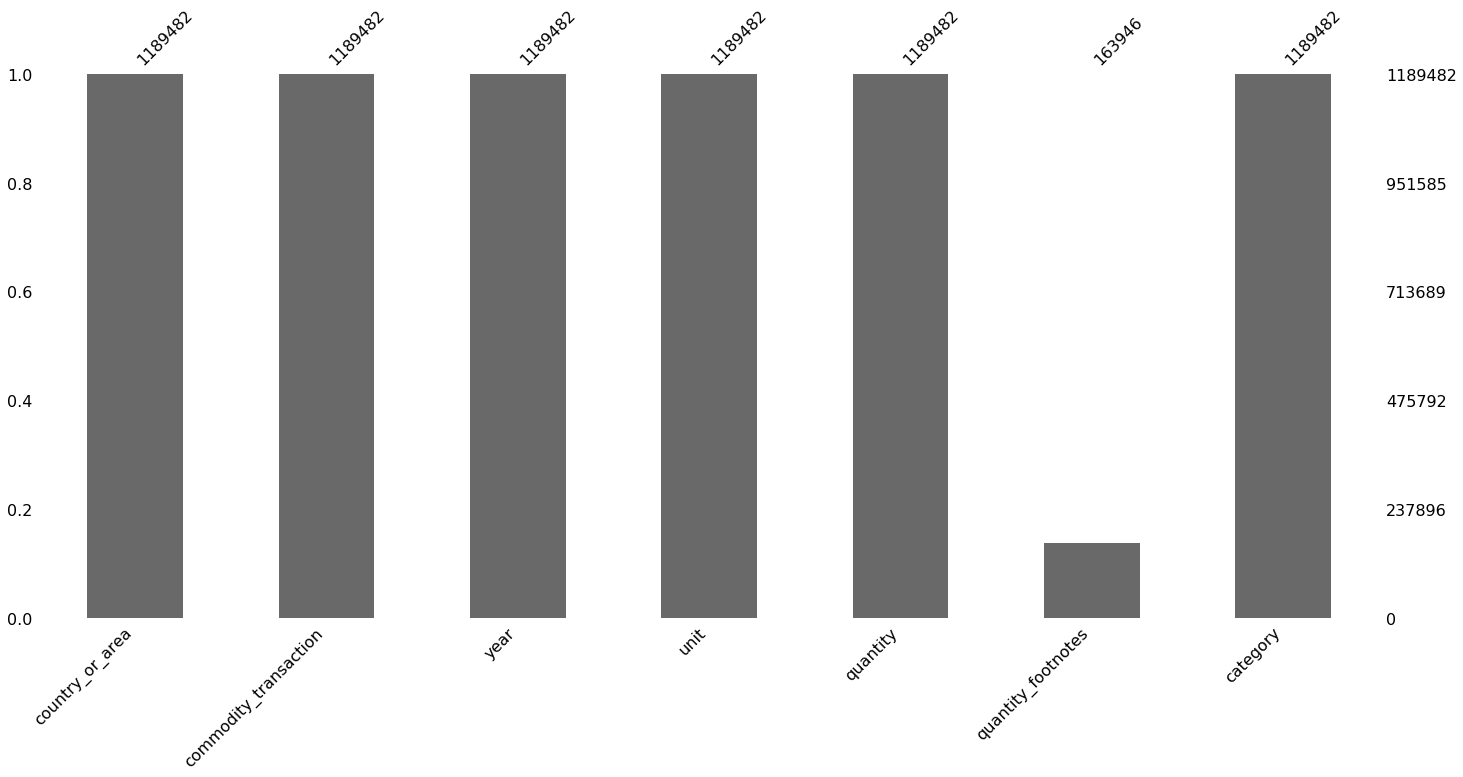

In [10]:
msno.bar(energy)
plt.show()

It seems that this column does not add anything to our analysis as it is mainly filled with NA's. Thus, we shall simply remove it from the dataset.

In [11]:
energy = energy.drop(['quantity_footnotes'], axis = 1)

In [12]:
energy.head()

,country_or_area,commodity_transaction,year,unit,quantity,category
0,Austria,Additives and Oxygenates - Exports,1996,"Metric tons, thousand",5.0,additives_and_oxygenates
1,Austria,Additives and Oxygenates - Exports,1995,"Metric tons, thousand",17.0,additives_and_oxygenates
2,Belgium,Additives and Oxygenates - Exports,2014,"Metric tons, thousand",0.0,additives_and_oxygenates
3,Belgium,Additives and Oxygenates - Exports,2013,"Metric tons, thousand",0.0,additives_and_oxygenates
4,Belgium,Additives and Oxygenates - Exports,2012,"Metric tons, thousand",35.0,additives_and_oxygenates


To avoid any unnecessary hiccups I want to convert all the string columns to lowercase.

In [13]:
energy['country_or_area'] = energy['country_or_area'].str.lower()
energy['commodity_transaction'] = energy['commodity_transaction'].str.lower()
energy['unit'] = energy['unit'].str.lower()
energy['category'] = energy['category'].str.lower()

In [14]:
# Simplify column names
energy.columns = ['country', 'commodity', 'year', 'unit', 'quantity', 'category']

The commodity column looks to have multiple pieces of information contained within each row. Therefore lets split it up and add those new columns back into our dataset.

In [15]:
energy.commodity.value_counts().head(10)

from combustible fuels – main activity                                                               6601
electricity - gross demand                                                                           5532
electricity - net production                                                                         5523
electricity - total production, main activity                                                        5523
electricity - gross production                                                                       5523
electricity - own use by electricity, heat and chp plants                                            5523
electricity - total net installed capacity of electric power plants, main activity & autoproducer    5521
electricity - total net installed capacity of electric power plants, main activity                   5521
electricity - final energy consumption                                                               5499
electricity - consumption by other            

In [16]:
# This tells us that there's a possibility of none, one, or two hyphens for the row elements.
energy.commodity.str.count(" - ").value_counts()

1    1112309
0      41416
2      35757
Name: commodity, dtype: int64

In [17]:
split_commodity = energy.commodity.str.split(" - | - ", expand = True)
split_commodity.head()

,0,1,2
0,additives and oxygenates,exports,None
1,additives and oxygenates,exports,None
2,additives and oxygenates,exports,None
3,additives and oxygenates,exports,None
4,additives and oxygenates,exports,None


In [18]:
split_commodity.columns = ['commodity type', 'transaction type', 'additional transaction info']

In [19]:
split_commodity['commodity type'].value_counts()

electricity                                                165140
gas oil/ diesel oil                                         97441
fuel oil                                                    75132
natural gas (including lng)                                 64161
motor gasoline                                              53198
                                                            ...  
from chemical heat – main activity – chp plants                19
from chemical heat – main activity – electricity plants        14
tide, wave and marine – autoproducer                            6
nuclear – autoproducer – chp plants                             5
municipal waste                                                 3
Name: commodity type, Length: 130, dtype: int64

In [20]:
split_commodity['additional transaction info'].unique()

array([None, 'main activity producers', 'autoproducers', 'total'],
      dtype=object)

In [21]:
# Add the split columns back onto the energy dataset
# *** BEWARE of running this more than once as it will keep concatenating columns and below code will not run *** #
energy = pd.concat([energy, split_commodity['commodity type'], split_commodity['transaction type'],
                   split_commodity['additional transaction info']], axis = 1)

In [22]:
# This selects certain countries from the energy dataset.
# Sorting by year as well as resetting the index helps with plotting later on.
def select_country(countryname):
    country_data = energy[energy.country.isin(countryname)].sort_values('year').reset_index()
    country_data.drop('index', axis = 1, inplace = True)
    return country_data

This will give us a helpful guide for knowing what country_data index matches to what country.

In [23]:
country_data = []
for c in energy['country'].unique():
    country_data.append(c + '_data')

for i in range(len(country_data)):
    print(i, '----', country_data[i])

0 ---- austria_data
1 ---- belgium_data
2 ---- czechia_data
3 ---- finland_data
4 ---- france_data
5 ---- greece_data
6 ---- hungary_data
7 ---- italy_data
8 ---- korea, republic of_data
9 ---- netherlands_data
10 ---- romania_data
11 ---- serbia_data
12 ---- slovakia_data
13 ---- ukraine_data
14 ---- united kingdom_data
15 ---- united states_data
16 ---- brunei darussalam_data
17 ---- bulgaria_data
18 ---- canada_data
19 ---- chile_data
20 ---- croatia_data
21 ---- iran (islamic rep. of)_data
22 ---- jordan_data
23 ---- lithuania_data
24 ---- mexico_data
25 ---- oman_data
26 ---- other asia_data
27 ---- poland_data
28 ---- portugal_data
29 ---- spain_data
30 ---- sweden_data
31 ---- switzerland_data
32 ---- t.f.yug.rep. macedonia_data
33 ---- turkey_data
34 ---- uzbekistan_data
35 ---- argentina_data
36 ---- colombia_data
37 ---- germany_data
38 ---- norway_data
39 ---- australia_data
40 ---- china, macao sar_data
41 ---- japan_data
42 ---- denmark_data
43 ---- ireland_data
44 ---- ph

In [24]:
for i in range(len(country_data)):
    country_data[i] = select_country([energy['country'].unique()[i]])

In [25]:
# Try it out for United States which in our case is index 15
country_data[15].sample(10)

,country,commodity,year,unit,quantity,category,commodity type,transaction type,additional transaction info
18262,united states,white spirit and special boiling point industr...,2013,"metric tons, thousand",445.0,white_spirit_and_special_boiling_point_industr...,white spirit and special boiling point industr...,imports,None
6773,united states,"lignite - consumption by other manuf., const. ...",1999,"metric tons, thousand",1136.0,lignite,lignite,"consumption by other manuf., const. and non-fu...",None
6340,united states,additives and oxygenates - stock changes,1999,"metric tons, thousand",-10.0,additives_and_oxygenates,additives and oxygenates,stock changes,None
13791,united states,gas oil/ diesel oil - consumption in rail,2008,"metric tons, thousand",9911.0,gas_oil_diesel_oil,gas oil/ diesel oil,consumption in rail,None
7801,united states,petroleum coke - transformation in electricity...,2001,"metric tons, thousand",75.0,petroleum_coke,petroleum coke,transformation in electricity plants,autoproducers
6762,united states,ethane - production from plants,1999,"metric tons, thousand",15081.0,ethane,ethane,production from plants,None
2278,united states,lignite brown coal - total known reserves,1993,"metric tons, thousand",204491000.0,brown_coal,lignite brown coal,total known reserves,None
9061,united states,electricity - exports,2002,"kilowatt-hours, million",13561.0,total_electricity,electricity,exports,None
19812,united states,natural gas (including lng) - consumption by o...,2014,terajoules,3313214.0,natural_gas_including_lng,natural gas (including lng),"consumption by other manuf., const. and non-fu...",None
3641,united states,"bagasse - consumption by manufacturing, constr...",1995,"metric tons, thousand",10679.0,bagasse,bagasse,"consumption by manufacturing, construction and...",None


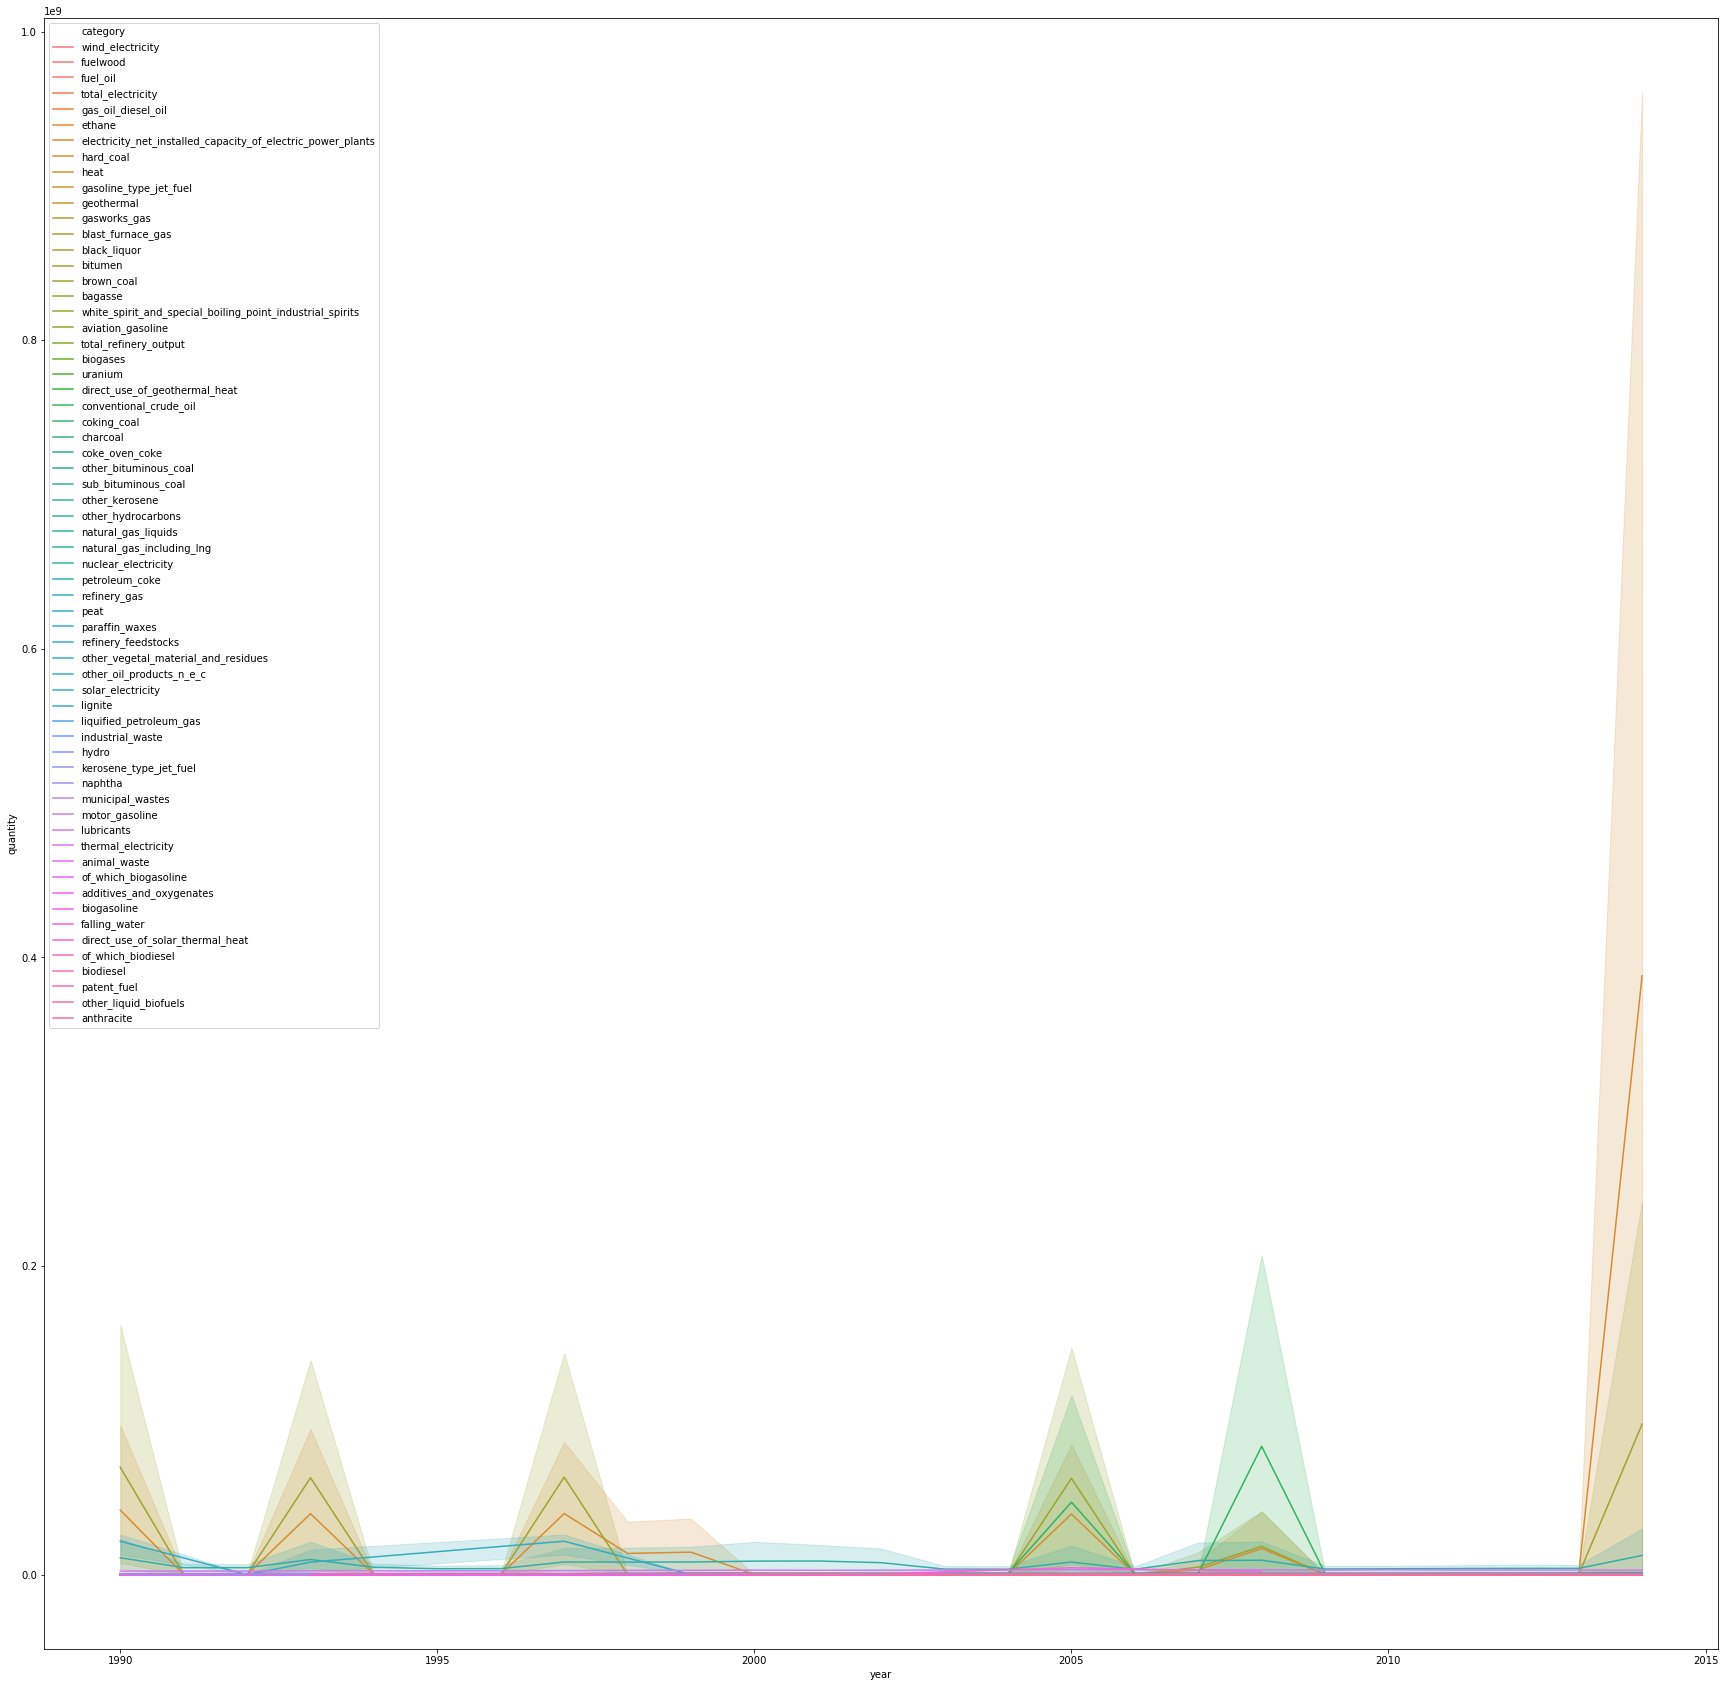

In [26]:
plt.figure(figsize=(30,30))
sns.lineplot(data = country_data[15], x = 'year', y = 'quantity', hue = 'category')
plt.show()

As can be seen there are far too many energy categories to have any sort of helpful visuals. Thus, below we create a function to choose specific categories from the data, following the same sort of thinking from the select_country function above.

In [27]:
# This functions follows the same thinking as above however, 
# it's for selecting energy category from the specific country data

def select_category(country_data, category_name):
    cat_country = country_data[country_data.category.isin(category_name)].sort_values('year').reset_index()
    cat_country.drop('index', axis = 1, inplace = True)
    return cat_country

In [28]:
crude_oil_us = select_category(country_data[15], ['conventional_crude_oil'])
wind_us = select_category(country_data[15], ['wind_electricity'])

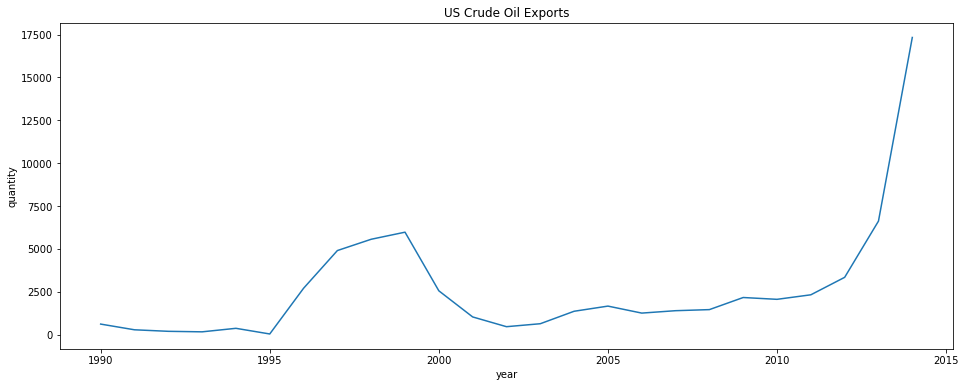

In [29]:
plt.figure(figsize=(16,6))
sns.lineplot(data = crude_oil_us[crude_oil_us['transaction type'] == 'exports'], x = 'year', y = 'quantity')
plt.title('US Crude Oil Exports')
plt.show()

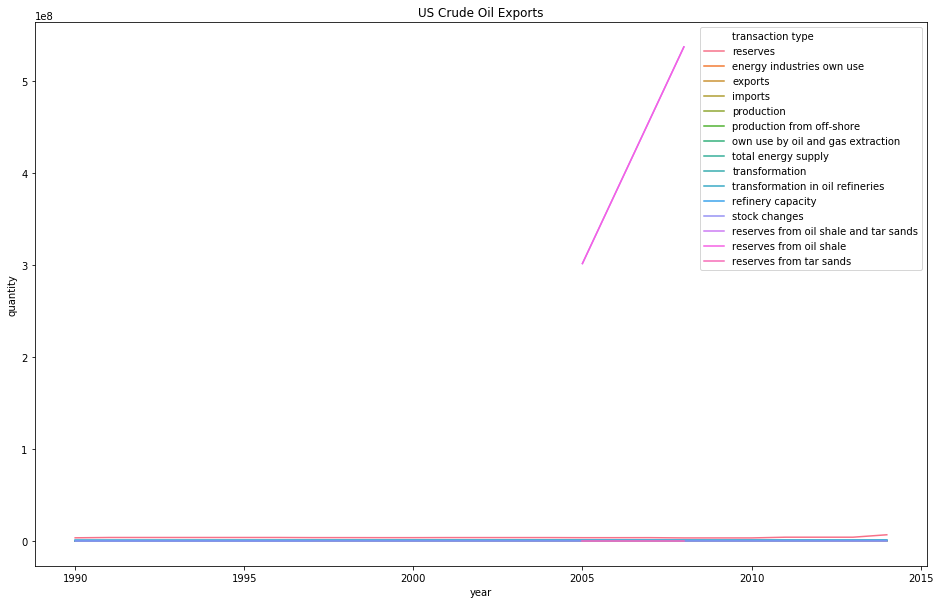

In [30]:
plt.figure(figsize=(16,10))
sns.lineplot(data = crude_oil_us, x = 'year', y = 'quantity', hue = 'transaction type')
plt.title('US Crude Oil Exports')
plt.show()

As can be seen there seems to be some outliers in the crude oil database for the US so we remove them below using the stats package along with the z score to tell us how far away from the mean a datapoint is.

In [31]:
from scipy import stats

# Checking out the outliers first, seems sufficient to remove them
crude_oil_us[(np.abs(stats.zscore(crude_oil_us['quantity'])) >= 3)]

,country,commodity,year,unit,quantity,category,commodity type,transaction type,additional transaction info
167,united states,crude petroleum - reserves from oil shale and ...,2005,"metric tons, thousand",301569021.0,conventional_crude_oil,crude petroleum,reserves from oil shale and tar sands,None
169,united states,crude petroleum - reserves from oil shale,2005,"metric tons, thousand",301566000.0,conventional_crude_oil,crude petroleum,reserves from oil shale,None
208,united states,crude petroleum - reserves from oil shale,2008,"metric tons, thousand",536931000.0,conventional_crude_oil,crude petroleum,reserves from oil shale,None
211,united states,crude petroleum - reserves from oil shale and ...,2008,"metric tons, thousand",536934025.0,conventional_crude_oil,crude petroleum,reserves from oil shale and tar sands,None


In [32]:
crude_oil_us = crude_oil_us[(np.abs(stats.zscore(crude_oil_us['quantity'])) < 3)]

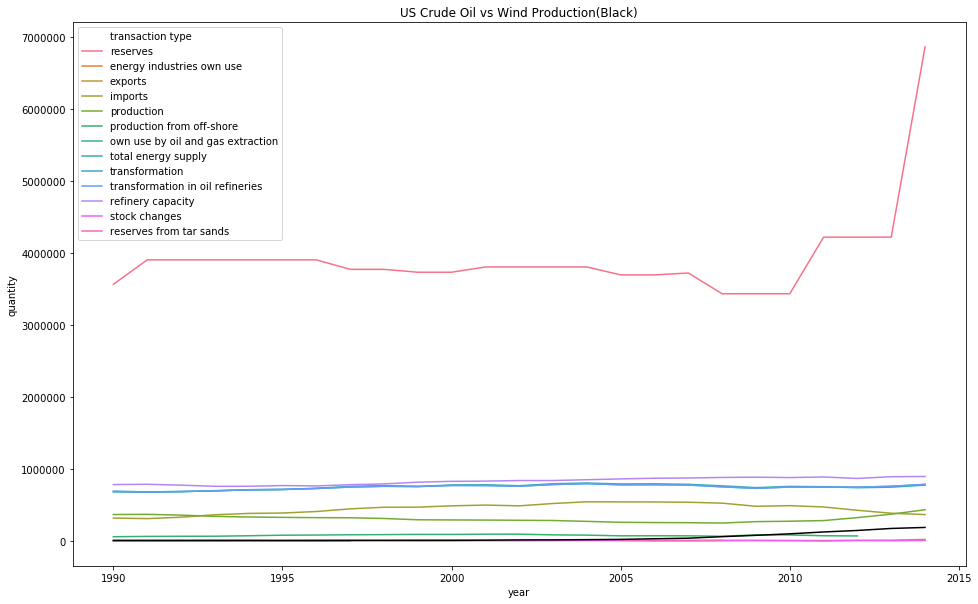

In [33]:
plt.figure(figsize=(16,10))
sns.lineplot(data = crude_oil_us, x = 'year', y = 'quantity', hue = 'transaction type')
sns.lineplot(data = wind_us, x = 'year', y = 'quantity', color = 'black')
plt.title('US Crude Oil vs Wind Production(Black)')
plt.show()

The following code is more a proof of concept than anything, but it does show how we can get descriptive plots for all the different energy categories for any single country, in this case the US.

In [34]:
us_means = {}
for c in country_data[15]['category'].unique():
    us_means[c] = (select_category(country_data[15], [c])['quantity'])

In [35]:
us_means_df = pd.DataFrame.from_dict(us_means)

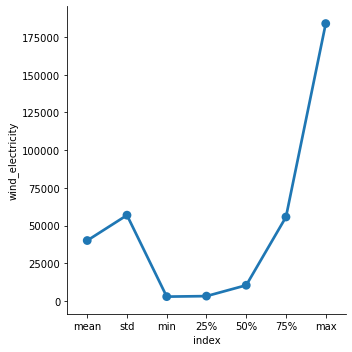

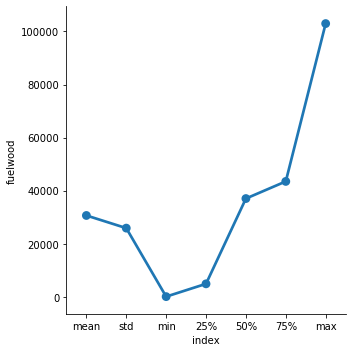

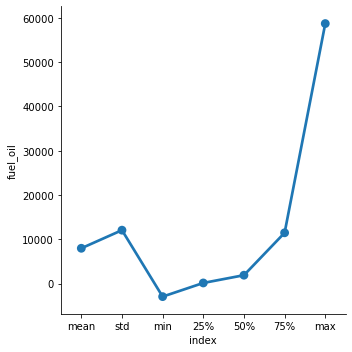

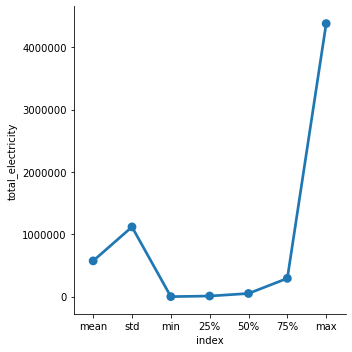

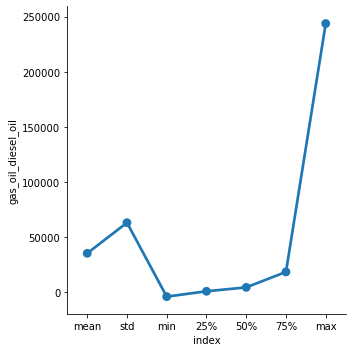

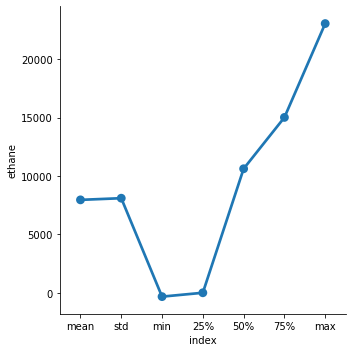

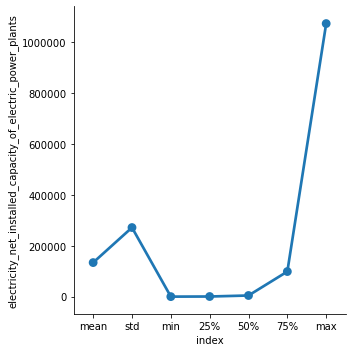

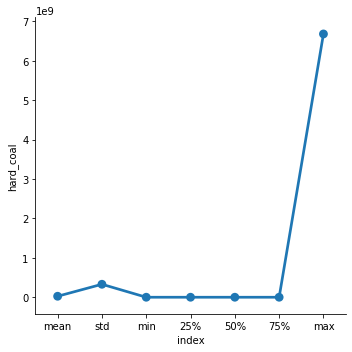

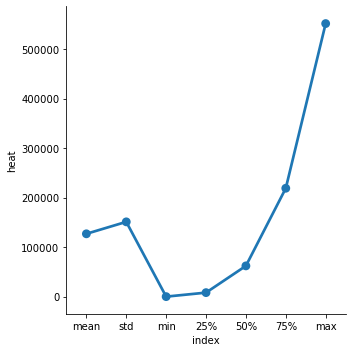

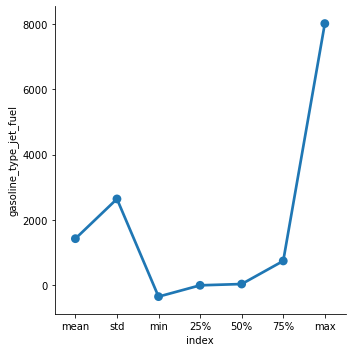

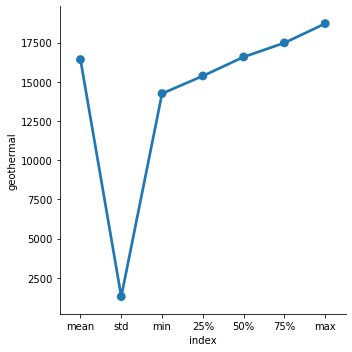

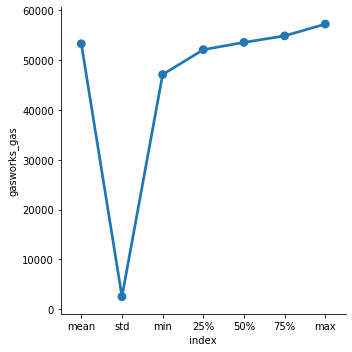

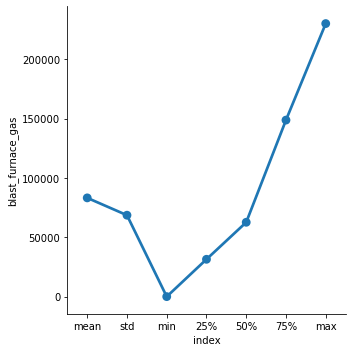

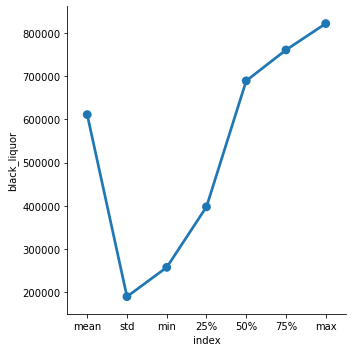

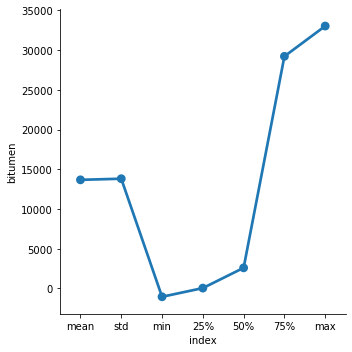

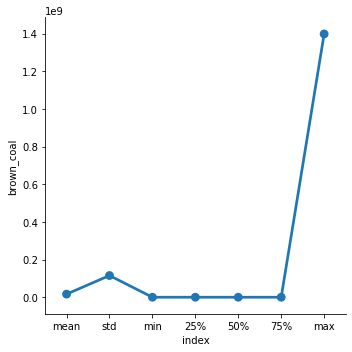

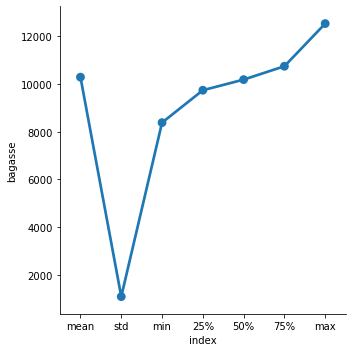

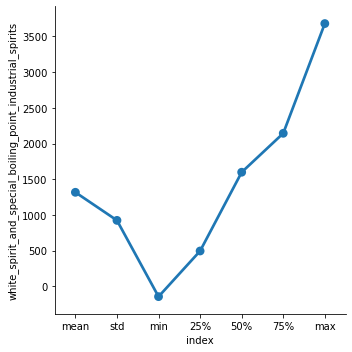

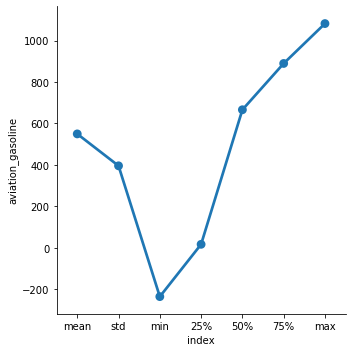

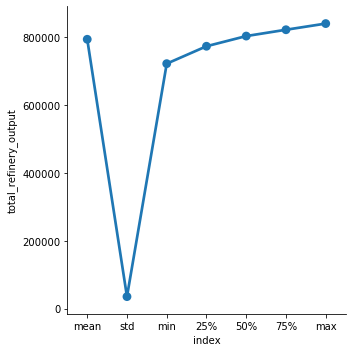

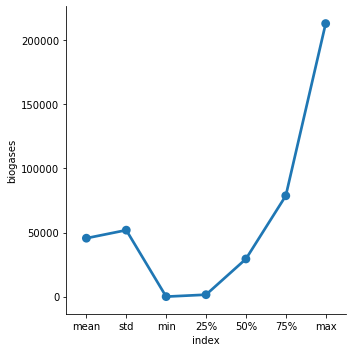

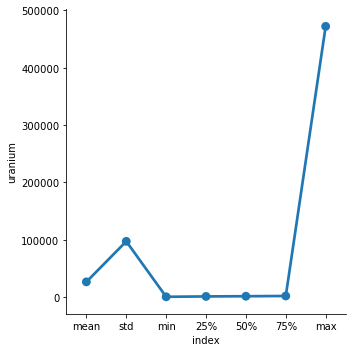

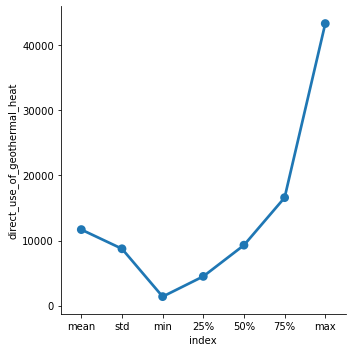

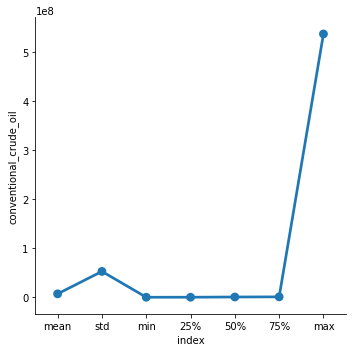

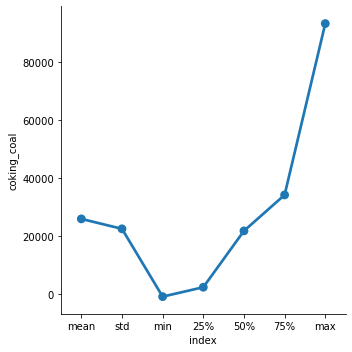

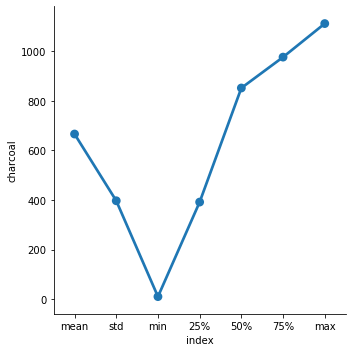

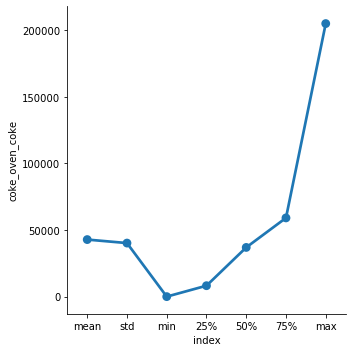

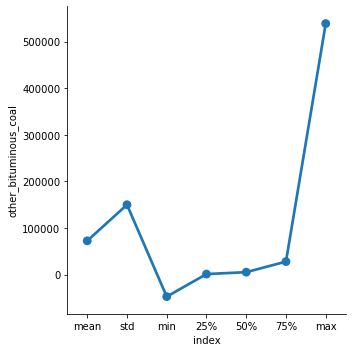

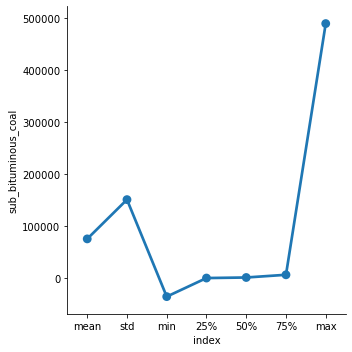

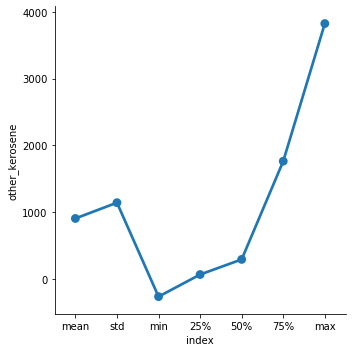

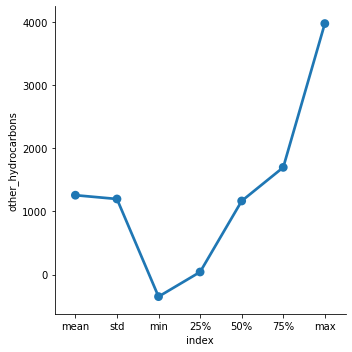

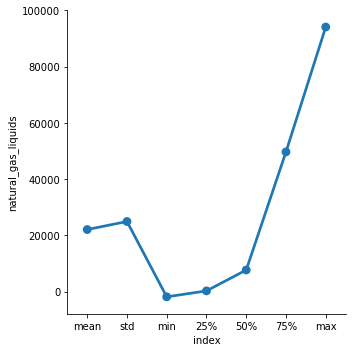

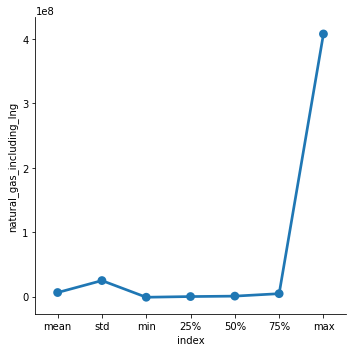

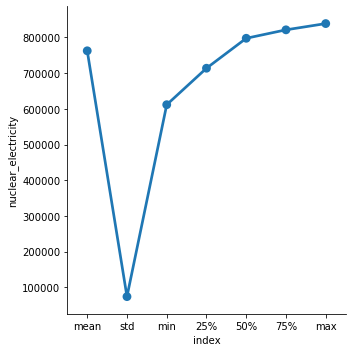

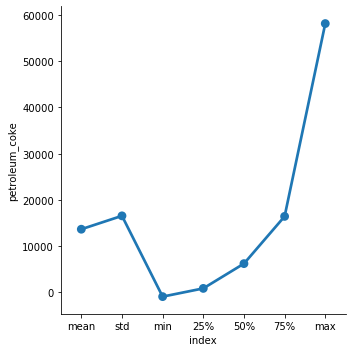

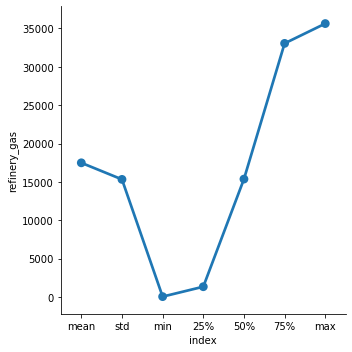

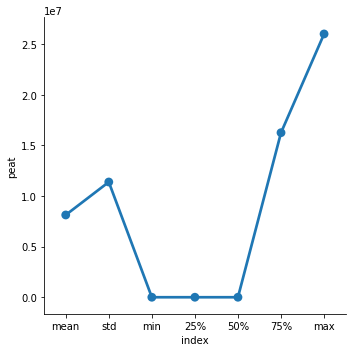

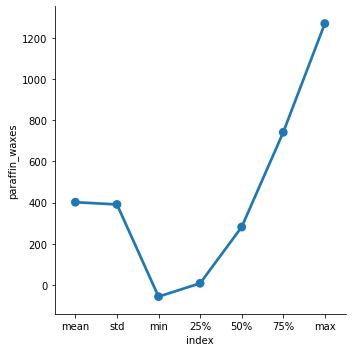

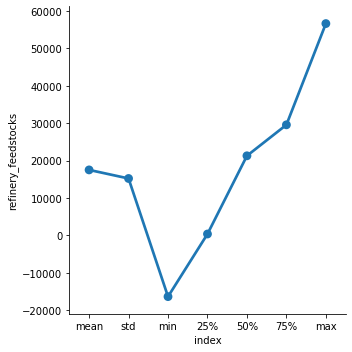

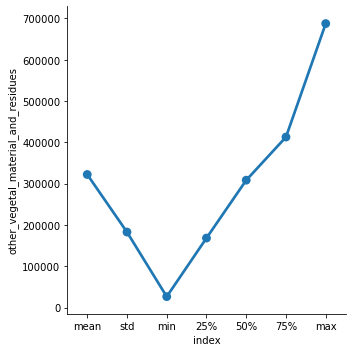

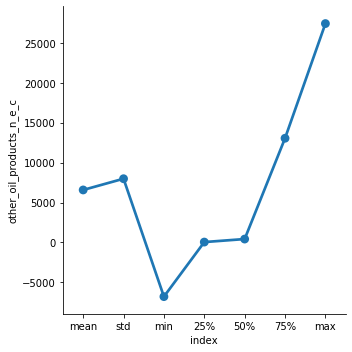

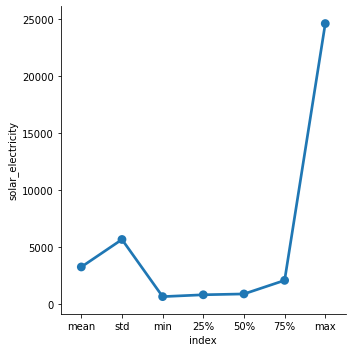

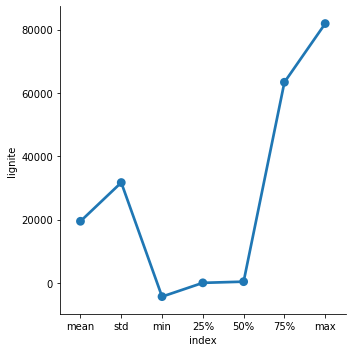

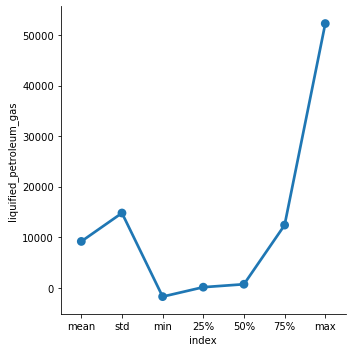

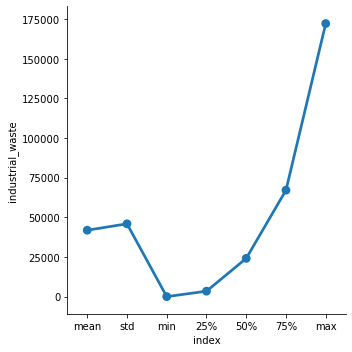

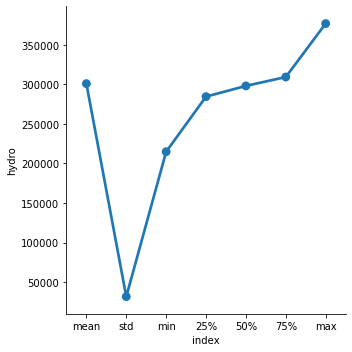

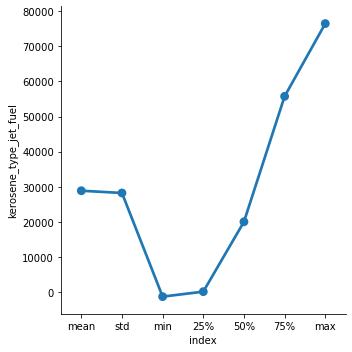

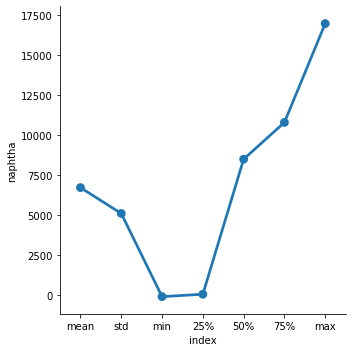

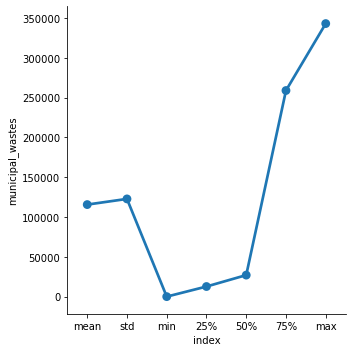

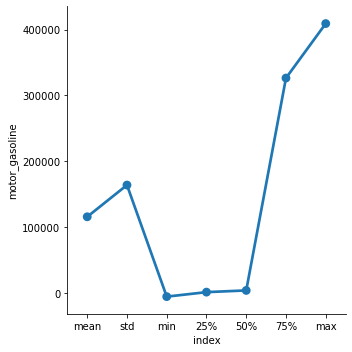

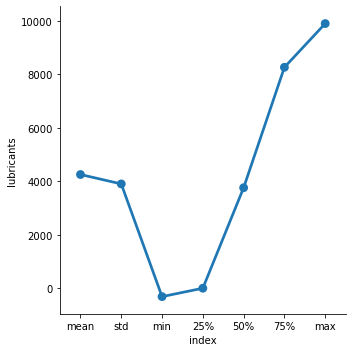

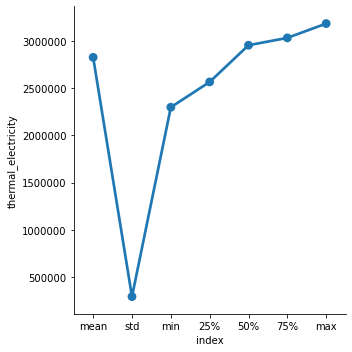

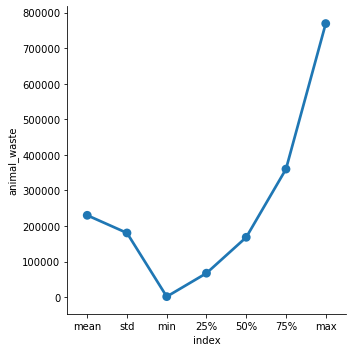

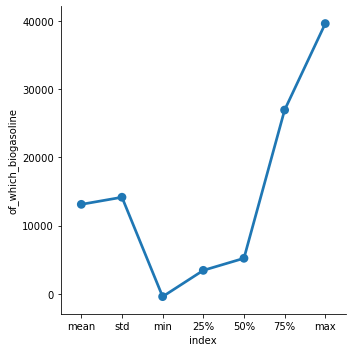

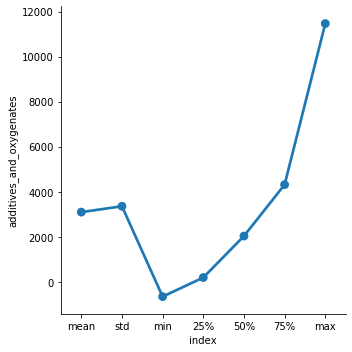

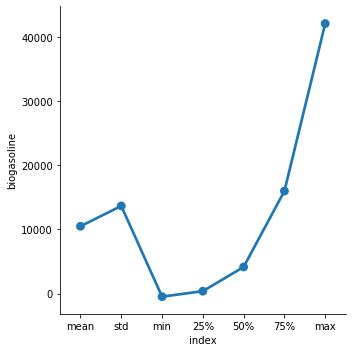

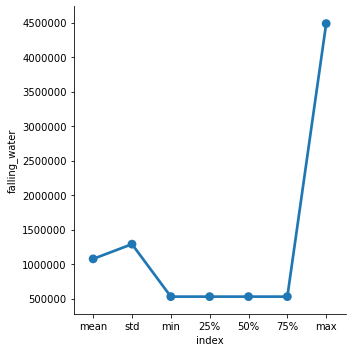

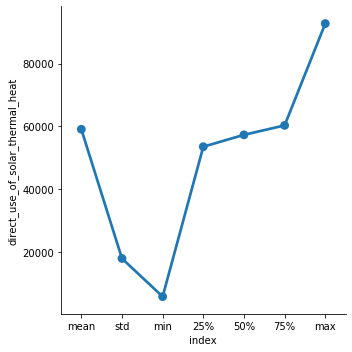

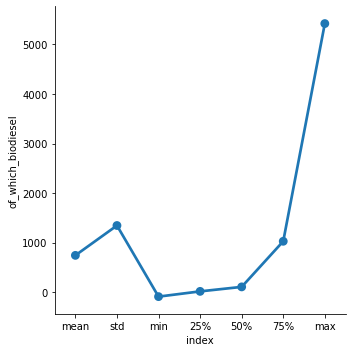

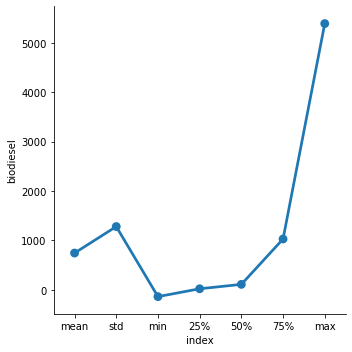

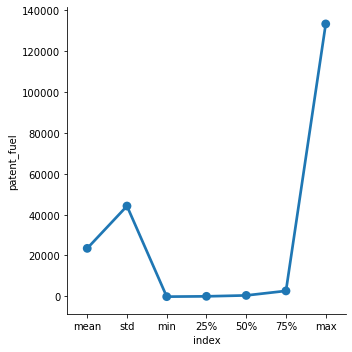

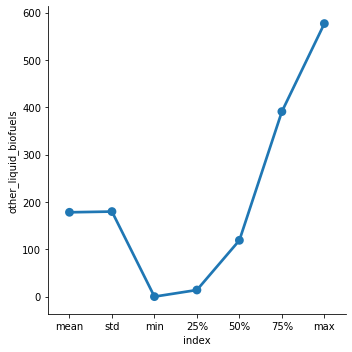

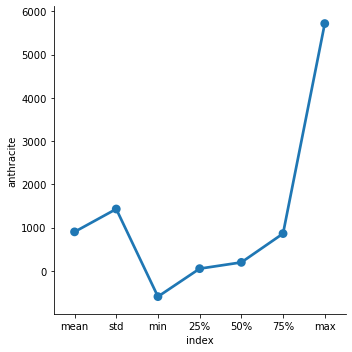

In [36]:
us_means_describe = us_means_df.describe()
us_means_describe.reset_index(inplace = True)

num_col = us_means_df._get_numeric_data().columns

us_means_describe = us_means_describe[us_means_describe['index'] != 'count']

for i in num_col:
    if i in ['index']:
        continue
    sns.catplot(x = 'index', y = i, data = us_means_describe, kind = 'point')
    plt.show()

### <center> Germany Data Visualization

In [37]:
# German Data
ger_dat = country_data[37]
country_data[37].head()


ger_means = {}
for c in ger_dat['category'].unique():
    ger_means[c] = (select_category(ger_dat, [c])['quantity'])
    
ger_means_df = pd.DataFrame.from_dict(ger_means)

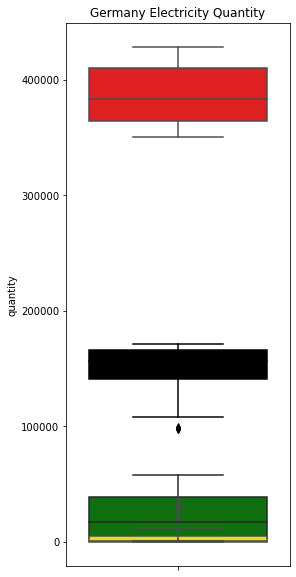

In [38]:
# wind electricity
# solar
# thermal
# nuclear
plt.figure(figsize=(4,10))
sns.boxplot(x = ger_means['wind_electricity'], orient='v', color = 'green')
sns.boxplot(x = ger_means['solar_electricity'], orient='v', color = 'yellow')
sns.boxplot(x = ger_means['thermal_electricity'], orient='v', color = 'red')
sns.boxplot(x = ger_means['nuclear_electricity'], orient='v', color = 'black')
plt.title('Germany Electricity Quantity')
plt.show()

Looks like thermal puts out the most electricity for Germany, followed by Nuclear, Wind, and Solar.

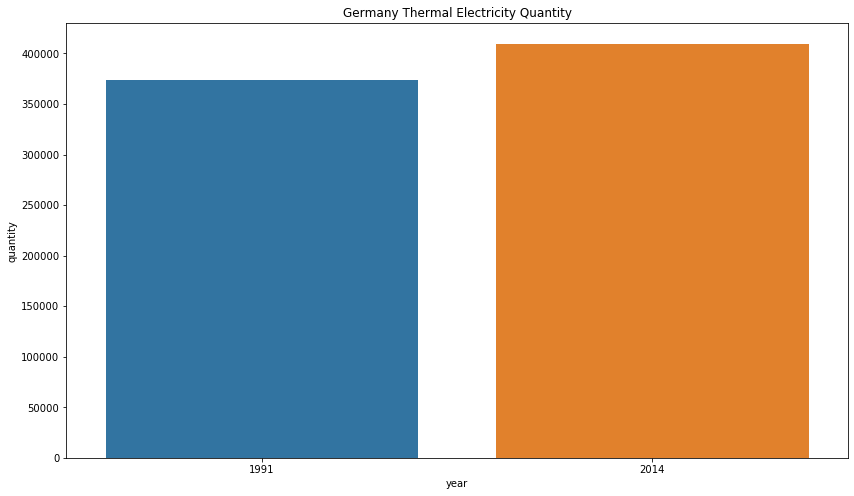

In [39]:
hl = country_data[37][(country_data[37]['year'] == 1991) | (country_data[37]['year'] == 2014)]
hl
plt.figure(figsize=(14,8))
sns.barplot(x = 'year', y = hl[hl['category'] == 'thermal_electricity']['quantity'], data = hl)
plt.title('Germany Thermal Electricity Quantity')
plt.show()

Suprisingly however there isn't much change between 1991 and 2014, this could mean Germany looking elsewhere for electricity generation when they were developing and expanding.

Text(0.5, 1.0, 'Solar')

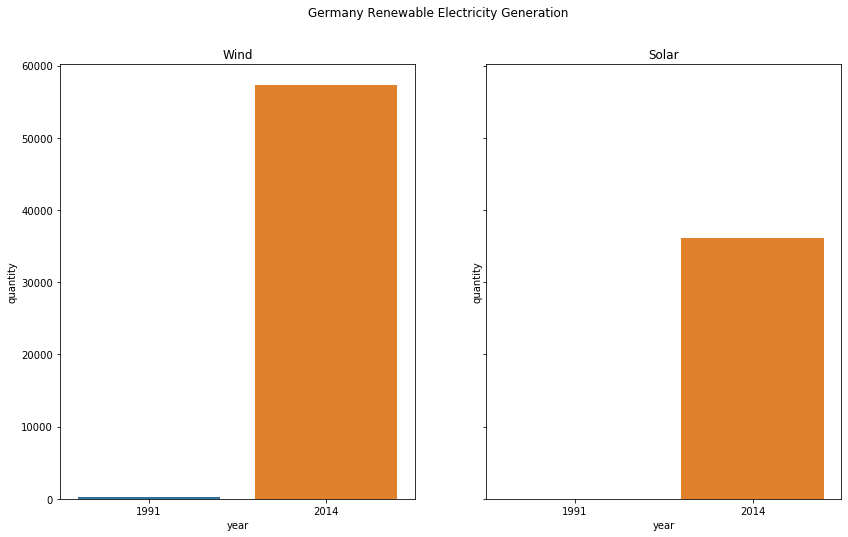

In [40]:
fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey = True)
fig.suptitle('Germany Renewable Electricity Generation')

sns.barplot(ax = ax[0], x = 'year', y = hl[hl['category'] == 'wind_electricity']['quantity'], data = hl)
ax[0].set_title('Wind')

sns.barplot(ax = ax[1], x = 'year', y = hl[hl['category'] == 'solar_electricity']['quantity'], data = hl)
ax[1].set_title('Solar')

Pretty massive jumps in wind and solar electricity between 1991, and 2014. Which is understandable as they became much more widely used technologies around the world.

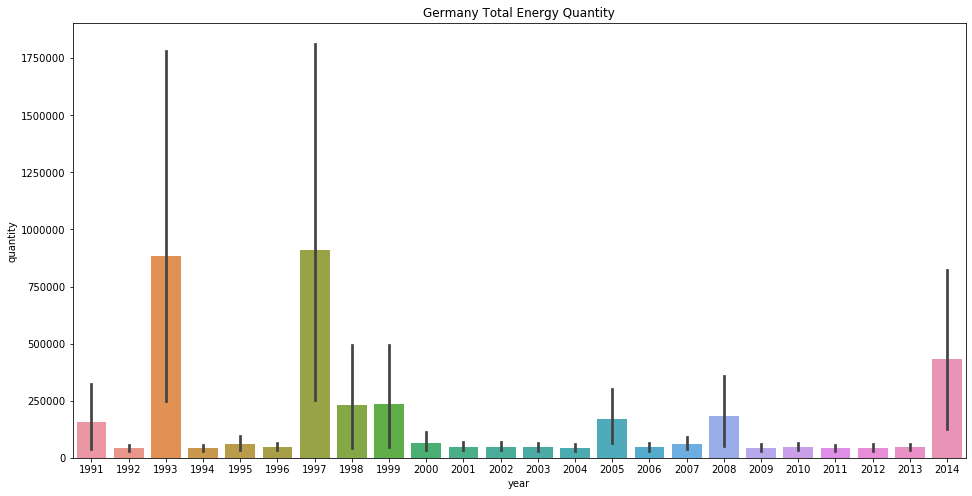

In [41]:
plt.figure(figsize=(16,8))
sns.barplot(x = 'year', y = 'quantity', data = country_data[37])
plt.title('Germany Total Energy Quantity')
plt.show()

It seems as though Germany went through some major expansions in 1993 and 1997 based on the total energy quantity.

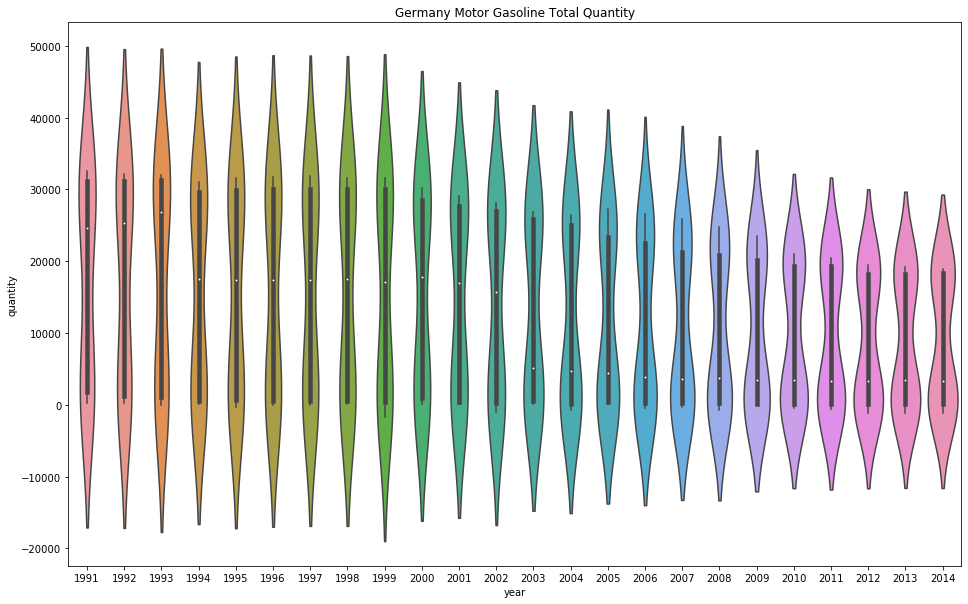

In [42]:
plt.figure(figsize=(16,10))
sns.violinplot(x = 'year', y = country_data[37][country_data[37]['category']=='motor_gasoline']['quantity'], 
               data = country_data[37])
plt.title('Germany Motor Gasoline Total Quantity')
plt.show()

You can see a slow decline in the total quantity of motor gasoline for Germany, perhaps suggesting a shift away from fossil fuels.

In [43]:
ger_impexp = ger_dat[(ger_dat['transaction type'].str.contains('exports')) | \
                     (ger_dat['transaction type'].str.contains('imports'))]

ger_mot = ger_impexp[(ger_impexp.category.str.contains('motor_gasoline'))]

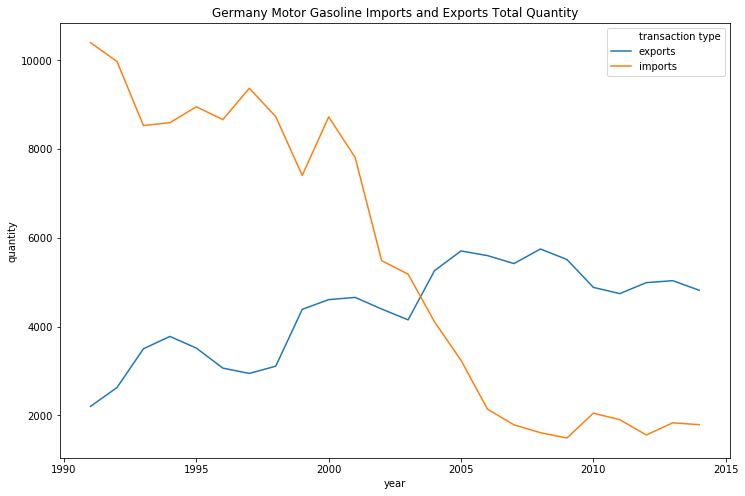

In [44]:
plt.figure(figsize=(12,8))
sns.lineplot(x = 'year', y = 'quantity', hue = 'transaction type', data = ger_mot)
plt.title('Germany Motor Gasoline Imports and Exports Total Quantity')
plt.show()

Again the sharp decline in imported motor gasoline seems to be signaling a shift away from fossil fuels for Germany.

In [45]:
ger_crud = ger_dat[ger_dat['category'] == 'conventional_crude_oil'][['year', 'quantity', 'commodity type', 'transaction type']]
ger_crud = ger_crud[ger_crud['transaction type'] != 'reserves from oil shale']
ger_crud = ger_crud[ger_crud['transaction type'] != 'reserves from oil shale and tar sands']

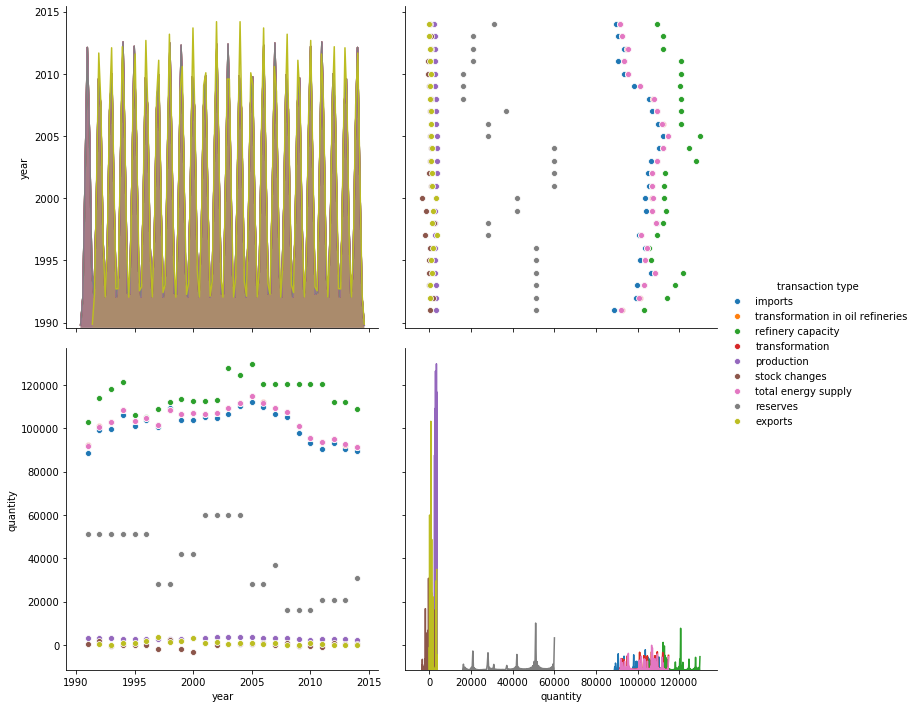

In [46]:
sns.pairplot(ger_crud, hue = 'transaction type', diag_kws={'bw': 0.2}, height=5)

This pairplot for conventional crude oil doesn't seem to show us much. Funny enough I had to remove the same reserves from oil shale, and reserves from oil shale and tar sands as I had to from the US crude oil data above.

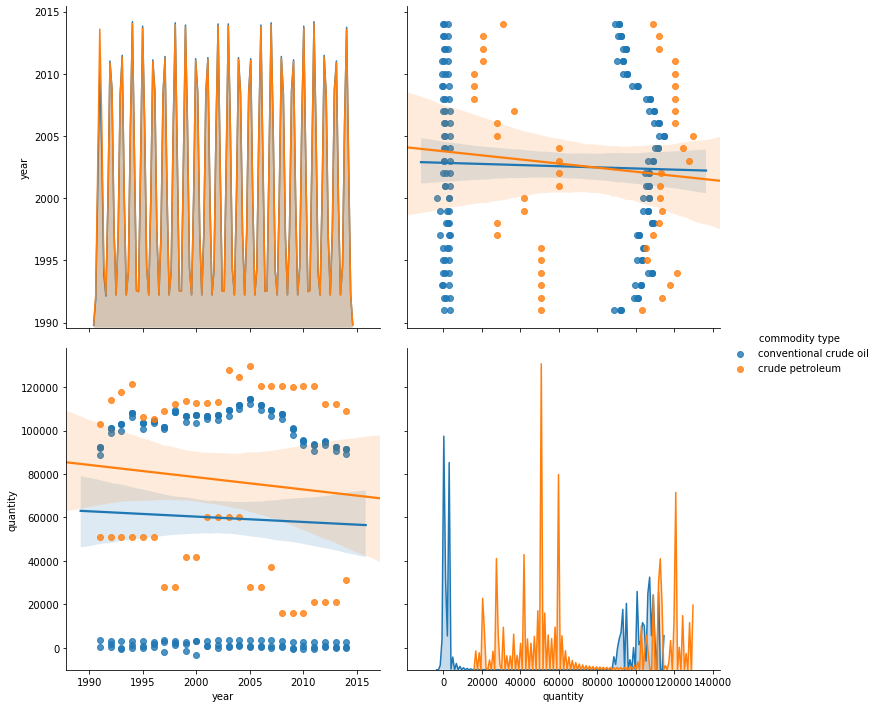

In [47]:
sns.pairplot(ger_crud, hue = 'commodity type', diag_kws={'bw': 0.2}, height=5, kind = 'reg')

In [48]:
# Lets compare Germany, US, Canada, and the United Kingdom
us_dat = country_data[15]
can_dat = country_data[18]
uk_dat = country_data[14]

## <center> Oil vs. Wind and Solar Visualizations

### <center> Crude Oil Production

In [49]:
us_crud_prod = us_dat[(us_dat['category'] == 'conventional_crude_oil') & \
                      (us_dat['transaction type'] == 'production')]

can_crud_prod = can_dat[(can_dat['category'] == 'conventional_crude_oil') & \
                      (can_dat['transaction type'].str.contains('production'))]

uk_crud_prod = uk_dat[(uk_dat['category'] == 'conventional_crude_oil') & \
                      (uk_dat['transaction type'].str.contains('production'))]

ger_crud_prod = ger_dat[(ger_dat['category'] == 'conventional_crude_oil') & \
                      (ger_dat['transaction type'].str.contains('production'))]

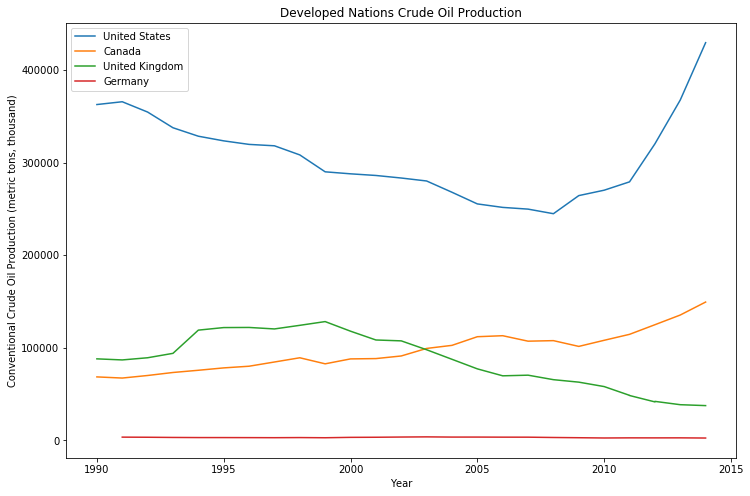

In [50]:
plt.figure(figsize=(12,8))
x1 = us_crud_prod.year
y1 = us_crud_prod.quantity
plt.plot(x1, y1, label = 'United States')

x2 = can_crud_prod.year
y2 = can_crud_prod.quantity
plt.plot(x2, y2, label = 'Canada')

x3 = uk_crud_prod.year
y3 = uk_crud_prod.quantity
plt.plot(x3, y3, label = 'United Kingdom')

x4 = ger_crud_prod.year
y4 = ger_crud_prod.quantity
plt.plot(x4, y4, label = 'Germany')

plt.legend(loc='best')
plt.xlabel("Year")
plt.ylabel("Conventional Crude Oil Production (metric tons, thousand)")
plt.title('Developed Nations Crude Oil Production')
plt.show()

### <center> Crude Oil Imports

In [51]:
us_crud_imp = us_dat[(us_dat['category'] == 'conventional_crude_oil') & \
                      (us_dat['transaction type'] == 'imports')]

can_crud_imp = can_dat[(can_dat['category'] == 'conventional_crude_oil') & \
                      (can_dat['transaction type'].str.contains('imports'))]

uk_crud_imp = uk_dat[(uk_dat['category'] == 'conventional_crude_oil') & \
                      (uk_dat['transaction type'].str.contains('imports'))]

ger_crud_imp = ger_dat[(ger_dat['category'] == 'conventional_crude_oil') & \
                      (ger_dat['transaction type'].str.contains('imports'))]

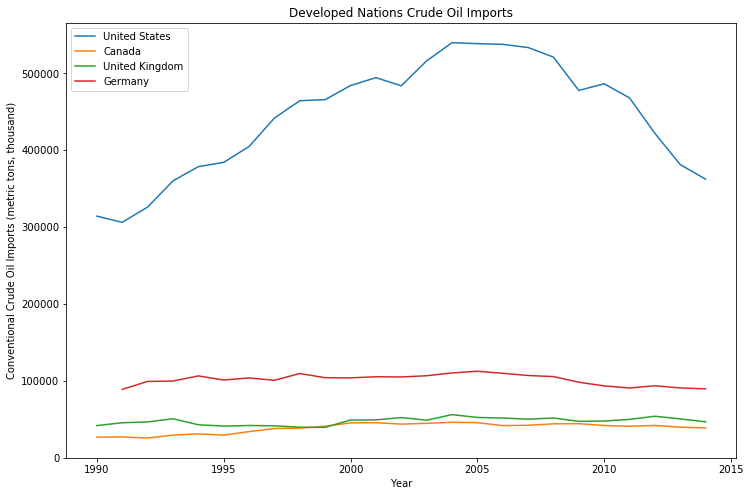

In [52]:
plt.figure(figsize=(12,8))
x1 = us_crud_imp.year
y1 = us_crud_imp.quantity
plt.plot(x1, y1, label = 'United States')

x2 = can_crud_imp.year
y2 = can_crud_imp.quantity
plt.plot(x2, y2, label = 'Canada')

x3 = uk_crud_imp.year
y3 = uk_crud_imp.quantity
plt.plot(x3, y3, label = 'United Kingdom')

x4 = ger_crud_imp.year
y4 = ger_crud_imp.quantity
plt.plot(x4, y4, label = 'Germany')

plt.legend(loc='best')
plt.xlabel("Year")
plt.ylabel("Conventional Crude Oil Imports (metric tons, thousand)")
plt.title('Developed Nations Crude Oil Imports')
plt.show()

Not suprisingly with the uptick in crude oil production for the United States the imports fell off

### <center> Wind Electricity

In [53]:
us_wind = us_dat[(us_dat['category'] == 'wind_electricity') & \
                      (us_dat['transaction type'].str.contains('production'))]

can_wind = can_dat[(can_dat['category'] == 'wind_electricity') & \
                      (can_dat['transaction type'].str.contains('production'))]

uk_wind = uk_dat[(uk_dat['category'] == 'wind_electricity') & \
                      (uk_dat['transaction type'].str.contains('production'))]

ger_wind = ger_dat[(ger_dat['category'] == 'wind_electricity') & \
                      (ger_dat['transaction type'].str.contains('production'))]

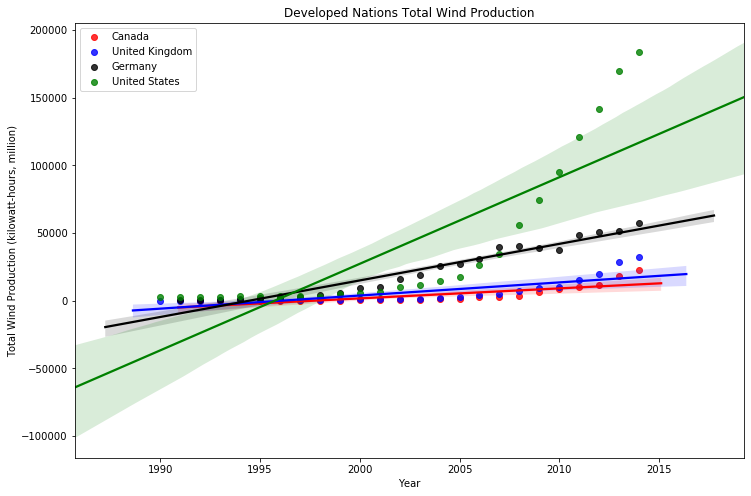

In [54]:
plt.figure(figsize=(12,8))
x2 = can_wind.year
y2 = can_wind.quantity
sns.regplot(x2, y2, label = 'Canada', color='red')

x3 = uk_wind.year
y3 = uk_wind.quantity
sns.regplot(x3, y3, label = 'United Kingdom', color='blue')

x4 = ger_wind.year
y4 = ger_wind.quantity
sns.regplot(x4, y4, label = 'Germany', color='black')

x1 = us_wind.year
y1 = us_wind.quantity
sns.regplot(x1, y1, label = 'United States', color='green')

plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Total Wind Production (kilowatt-hours, million)")
plt.title('Developed Nations Total Wind Production')
plt.show()

Looks like the wind production within the United States has really ramped up in recent years as well as the other countries increasing steadily.

### <center> Solar Electricity

In [55]:
us_sol = us_dat[(us_dat['category'] == 'solar_electricity') & \
                      (us_dat['transaction type'].str.contains('production'))]

can_sol = can_dat[(can_dat['category'] == 'solar_electricity') & \
                      (can_dat['transaction type'].str.contains('production'))]

uk_sol = uk_dat[(uk_dat['category'] == 'solar_electricity') & \
                      (uk_dat['transaction type'].str.contains('production'))]

ger_sol = ger_dat[(ger_dat['category'] == 'solar_electricity') & \
                      (ger_dat['transaction type'].str.contains('production'))]

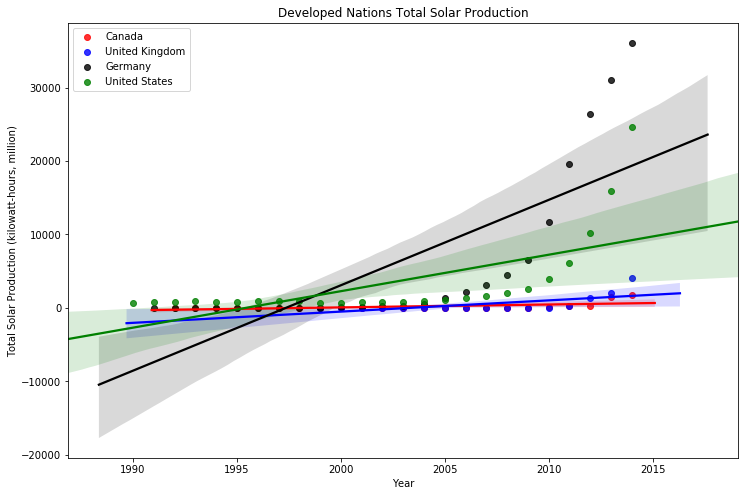

In [56]:
plt.figure(figsize=(12,8))
x2 = can_sol.year
y2 = can_sol.quantity
sns.regplot(x2, y2, label = 'Canada', color='red')

x3 = uk_sol.year
y3 = uk_sol.quantity
sns.regplot(x3, y3, label = 'United Kingdom', color='blue')

x4 = ger_sol.year
y4 = ger_sol.quantity
sns.regplot(x4, y4, label = 'Germany', color='black')

x1 = us_sol.year
y1 = us_sol.quantity
sns.regplot(x1, y1, label = 'United States', color='green')

plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Total Solar Production (kilowatt-hours, million)")
plt.title('Developed Nations Total Solar Production')
plt.show()

Germany far outpacing other countries for solar production with the US trying to close the gap. Tune in in 25 years to find out the winner.

### <center> Smaller Countries Analysis

In [57]:
# Malaysia, Ireland, Slovenia, Netherlands

neth_dat = country_data[9]
ire_dat = country_data[43]
mal_dat = country_data[116]
slo_dat = country_data[133]

In [58]:
neth_crud_prod = neth_dat[(neth_dat['category'] == 'conventional_crude_oil') & \
                      (neth_dat['transaction type'] == 'production')]

ire_crud_prod = ire_dat[(ire_dat['category'] == 'conventional_crude_oil') & \
                      (ire_dat['transaction type'].str.contains('production'))]

mal_crud_prod = mal_dat[(mal_dat['category'] == 'conventional_crude_oil') & \
                      (mal_dat['transaction type'].str.contains('production'))]

slo_crud_prod = slo_dat[(slo_dat['category'] == 'conventional_crude_oil') & \
                      (slo_dat['transaction type'].str.contains('production'))]

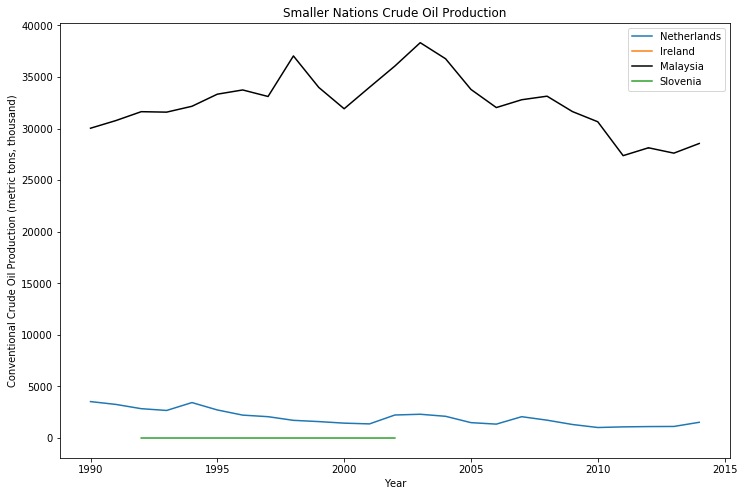

In [59]:
plt.figure(figsize=(12,8))
x1 = neth_crud_prod.year
y1 = neth_crud_prod.quantity
plt.plot(x1, y1, label = 'Netherlands')

x2 = ire_crud_prod.year
y2 = ire_crud_prod.quantity
plt.plot(x2, y2, label = 'Ireland')

x3 = mal_crud_prod.year
y3 = mal_crud_prod.quantity
plt.plot(x3, y3, label = 'Malaysia', color = 'black')

x4 = slo_crud_prod.year
y4 = slo_crud_prod.quantity
plt.plot(x4, y4, label = 'Slovenia')

plt.legend(loc='best')
plt.xlabel("Year")
plt.ylabel("Conventional Crude Oil Production (metric tons, thousand)")
plt.title('Smaller Nations Crude Oil Production')
plt.show()

In [60]:
neth_crud_imp = neth_dat[(neth_dat['category'] == 'conventional_crude_oil') & \
                      (neth_dat['transaction type'] == 'imports')]

ire_crud_imp = ire_dat[(ire_dat['category'] == 'conventional_crude_oil') & \
                      (ire_dat['transaction type'].str.contains('imports'))]

mal_crud_imp = mal_dat[(mal_dat['category'] == 'conventional_crude_oil') & \
                      (mal_dat['transaction type'].str.contains('imports'))]

slo_crud_imp = slo_dat[(slo_dat['category'] == 'conventional_crude_oil') & \
                      (slo_dat['transaction type'].str.contains('imports'))]

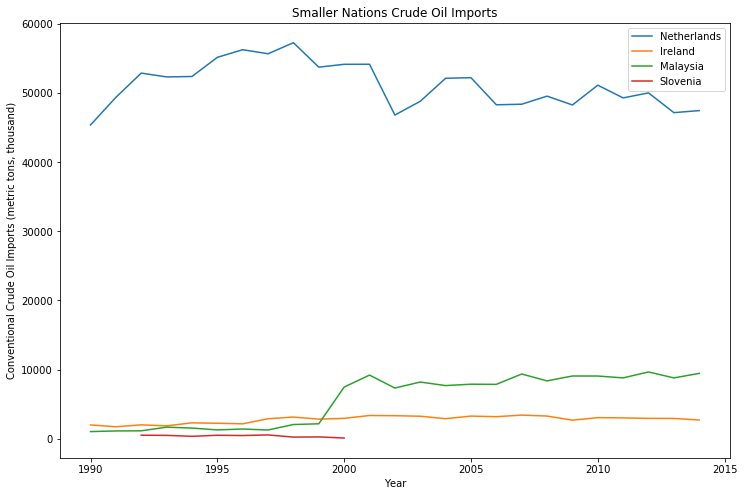

In [61]:
plt.figure(figsize=(12,8))
x1 = neth_crud_imp.year
y1 = neth_crud_imp.quantity
plt.plot(x1, y1, label = 'Netherlands')

x2 = ire_crud_imp.year
y2 = ire_crud_imp.quantity
plt.plot(x2, y2, label = 'Ireland')

x3 = mal_crud_imp.year
y3 = mal_crud_imp.quantity
plt.plot(x3, y3, label = 'Malaysia')

x4 = slo_crud_imp.year
y4 = slo_crud_imp.quantity
plt.plot(x4, y4, label = 'Slovenia')

plt.legend(loc='best')
plt.xlabel("Year")
plt.ylabel("Conventional Crude Oil Imports (metric tons, thousand)")
plt.title('Smaller Nations Crude Oil Imports')
plt.show()

In [62]:
neth_wind = neth_dat[(neth_dat['category'] == 'wind_electricity') & \
                      (neth_dat['transaction type'].str.contains('production'))]

ire_wind = ire_dat[(ire_dat['category'] == 'wind_electricity') & \
                      (ire_dat['transaction type'].str.contains('production'))]

mal_wind = mal_dat[(mal_dat['category'] == 'wind_electricity') & \
                      (mal_dat['transaction type'].str.contains('production'))]

slo_wind = slo_dat[(slo_dat['category'] == 'wind_electricity') & \
                      (slo_dat['transaction type'].str.contains('production'))]

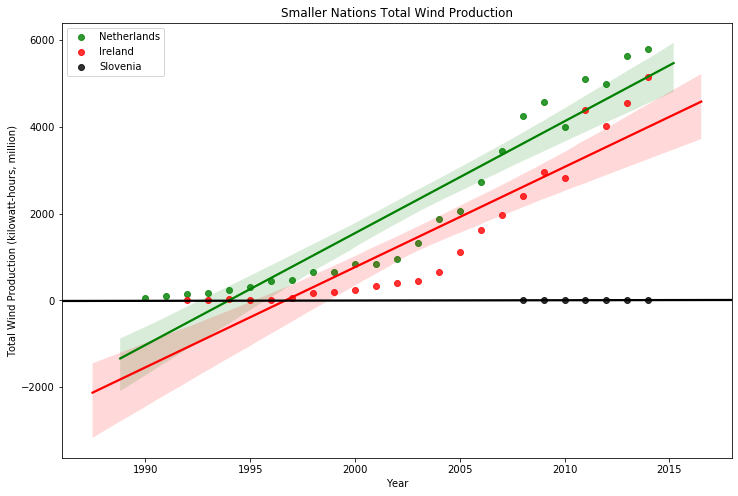

In [63]:
plt.figure(figsize=(12,8))
x1 = neth_wind.year
y1 = neth_wind.quantity
sns.regplot(x1, y1, label = 'Netherlands', color='green')

x2 = ire_wind.year
y2 = ire_wind.quantity
sns.regplot(x2, y2, label = 'Ireland', color='red')

# x3 = mal_wind.year
# y3 = mal_wind.quantity
# sns.regplot(x3, y3, label = 'Malaysia', color='blue')

x4 = slo_wind.year
y4 = slo_wind.quantity
sns.regplot(x4, y4, label = 'Slovenia', color='black')

plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Total Wind Production (kilowatt-hours, million)")
plt.title('Smaller Nations Total Wind Production')
plt.show()

In [64]:
neth_sol = neth_dat[(neth_dat['category'] == 'solar_electricity') & \
                      (neth_dat['transaction type'].str.contains('production'))]

ire_sol = ire_dat[(ire_dat['category'] == 'solar_electricity') & \
                      (ire_dat['transaction type'].str.contains('production'))]

mal_sol = mal_dat[(mal_dat['category'] == 'solar_electricity') & \
                      (mal_dat['transaction type'].str.contains('production'))]

slo_sol = slo_dat[(slo_dat['category'] == 'solar_electricity') & \
                      (slo_dat['transaction type'].str.contains('production'))]

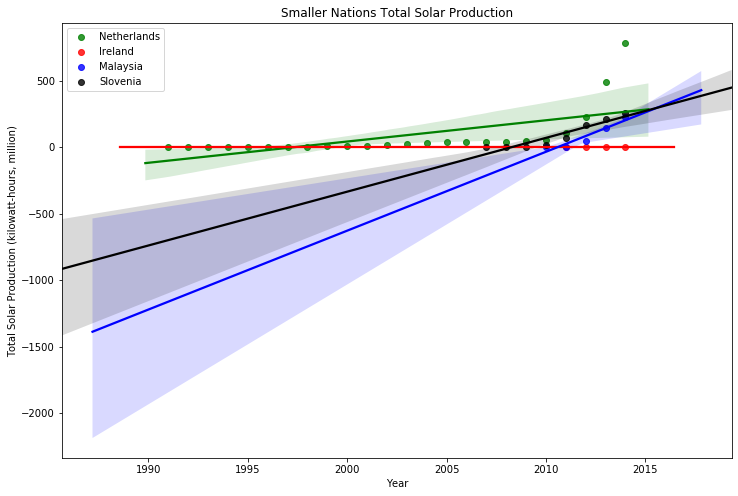

In [65]:
plt.figure(figsize=(12,8))
x1 = neth_sol.year
y1 = neth_sol.quantity
sns.regplot(x1, y1, label = 'Netherlands', color='green')

x2 = ire_sol.year
y2 = ire_sol.quantity
sns.regplot(x2, y2, label = 'Ireland', color='red')

x3 = mal_sol.year
y3 = mal_sol.quantity
sns.regplot(x3, y3, label = 'Malaysia', color='blue')

x4 = slo_sol.year
y4 = slo_sol.quantity
sns.regplot(x4, y4, label = 'Slovenia', color='black')

plt.legend(loc='upper left')
plt.xlabel("Year")
plt.ylabel("Total Solar Production (kilowatt-hours, million)")
plt.title('Smaller Nations Total Solar Production')
plt.show()

There isn't much to report on with the crude oil production or imports as there doesn't seem to be much of note. However, the Netherlands and Ireland look to be neck and neck for wind production, with Malaysia having no information. Solar production was suprising as well, with the Netherlands having a large leap, Ireland actually decreasing, and Malaysia making a strong push as well.

#### Sources:
(1) https://unstats.un.org/unsd/energystats/questionnaire/documents/Energy-Questionnaire-Guidelines.pdf